In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import zipfile
import io
from pathlib import Path
import time
import matplotlib.pyplot as plt

# Data

In [2]:
def download_binance_data(symbol, data_type, date, market_type="futures/um"):
    base_url = "https://data.binance.vision"
    if data_type.startswith('klines'):
        interval = data_type.split('_')[1]
        url = f"{base_url}/data/{market_type}/daily/klines/{symbol}/{interval}/{symbol}-{interval}-{date}.zip"
    else:
        url = f"{base_url}/data/{market_type}/daily/{data_type}/{symbol}/{symbol}-{data_type}-{date}.zip"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_filename = z.namelist()[0]
            with z.open(csv_filename) as f:
                df = pd.read_csv(f)
        return df
    
    except requests.exceptions.HTTPError as e:
        return None

In [3]:
date = "2025-11-10"

This contains every single trade execution on the exchange. Someone either hit a bid (sell market order) or lifted an ask (buy market order). The `is_buyer_maker` field tells us the direction: FALSE means aggressive buying (lifted ask), TRUE means aggressive selling (hit bid). 

We use this to measure order flow imbalance and trade arrival rates, which tell us whether smart money is buying or selling. High buy flow suggests continuation, while extreme flow can signal exhaustion for mean reversion.

In [4]:
aggregate_trades_df = download_binance_data("SOLUSDT", "aggTrades", date, "futures/um")

In [5]:
aggregate_trades_df['timestamp'] = pd.to_datetime(aggregate_trades_df['transact_time'], unit='ms')
aggregate_trades_df['price'] = aggregate_trades_df['price'].astype(float)
aggregate_trades_df['quantity'] = aggregate_trades_df['quantity'].astype(float)

This contains aggregate market sentiment and positioning data collected every 5 minutes, including open interest, top trader positioning, and taker buy/sell volume ratios. 

Open interest shows total outstanding contracts (rising OI + rising price = strong trend, rising OI + falling price = distribution). 

The top trader long/short ratio reveals what institutional/large traders are doing: values >1 mean they're net long (bullish), <1 means net short (bearish). 

We use these as both directional signals (follow the smart money) and contrarian indicators (extreme positioning often precedes reversals, e.g., when everyone's long at ratio >3, who's left to buy?).

In [8]:
metrics_df = download_binance_data("SOLUSDT", "metrics", date, "futures/um")

In [9]:
metrics_df['timestamp'] = pd.to_datetime(metrics_df['create_time'])
metrics_df['open_interest'] = metrics_df['sum_open_interest'].astype(float)
metrics_df['toptrader_ratio'] = metrics_df['sum_toptrader_long_short_ratio'].astype(float)
metrics_df['longshort_ratio'] = metrics_df['count_long_short_ratio'].astype(float)
metrics_df['taker_ratio'] = metrics_df['sum_taker_long_short_vol_ratio'].astype(float)


These are aggregated OHLCV (Open, High, Low, Close, Volume) candlesticks that give us price action and volume at regular intervals. We use them primarily for volatility estimation (required for the Avellaneda-Stoikov model) and to detect trending vs mean-reverting regimes. The `taker_buy_base_volume` field shows us aggressive buying pressure within each minute. 

This is our "macro" view while aggTrades gives us the "micro" tick-level flow.

In [72]:
klines_df = download_binance_data("SOLUSDT", "klines_1m", date, "futures/um")

In [73]:
klines_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'trades', 'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore']
klines_df['timestamp'] = pd.to_datetime(klines_df['open_time'], unit='ms')
for col in ['open', 'high', 'low', 'close', 'volume', 'taker_buy_base_volume']:
    klines_df[col] = klines_df[col].astype(float)

This shows cumulative order book depth at percentage levels from mid price (e.g., -1% = bids 1% below mid, +1% = asks 1% above mid). We calculate book imbalance by comparing bid vs ask depth at each level - more bid depth suggests buying pressure building. 

Changes in total liquidity warn us about volatility spikes (liquidity drops = wider spreads = harder to execute). This complements aggTrades by showing passive liquidity (limit orders) vs aggressive flow (market orders).RetryEF

In [74]:
depth_df = download_binance_data("SOLUSDT", "bookDepth", date, "futures/um")

In [75]:
depth_df['timestamp'] = pd.to_datetime(depth_df['timestamp'])
depth_df['depth'] = depth_df['depth'].astype(float)
depth_df['percentage'] = depth_df['percentage'].astype(int)

In [76]:
print(f"aggTrades: {len(aggregate_trades_df):,} rows")
print(f"klines: {len(klines_df):,} rows")
print(f"funding: {len(metrics_df):,} rows")
print(f"depth: {len(depth_df):,} rows")

aggTrades: 491,334 rows
klines: 1,440 rows
funding: 288 rows
depth: 27,400 rows


We resample tick-level aggTrades into 1-minute bars to align with our other data sources. The `buy_ratio` tells us what fraction of trades in that minute were aggressive buys (lifted the ask) vs aggressive sells (hit the bid). This captures short-term order flow momentum: for example, a `buy_ratio` > 0.6 means buyers are dominating that minute. We use this to detect whether smart money is accumulating (consistent high `buy_ratio`) or distributing (consistent low `buy_ratio`).

In [77]:
trades_1min = aggregate_trades_df.set_index('timestamp').resample('1min').agg({
    'price': 'last',
    'quantity': 'sum',
    'is_buyer_maker': lambda x: (~x).sum() / len(x) if len(x) > 0 else 0.5
}).rename(columns={'quantity': 'volume', 'is_buyer_maker': 'buy_ratio'})

In [78]:
trades_1min['buy_volume'] = trades_1min['volume'] * trades_1min['buy_ratio']
trades_1min['sell_volume'] = trades_1min['volume'] * (1 - trades_1min['buy_ratio'])
trades_1min['flow_imbalance'] = (trades_1min['buy_volume'] - trades_1min['sell_volume']) / trades_1min['volume']
trades_1min['trade_intensity'] = trades_1min['volume']

trades_1min.head()

,price,volume,buy_ratio,buy_volume,sell_volume,flow_imbalance,trade_intensity
timestamp,,,,,,,
2025-11-10 00:00:00,164.40,18475.21,0.481481,8895.471481,9579.738519,-0.037037,18475.21
2025-11-10 00:01:00,163.92,63137.63,0.365188,23057.086724,40080.543276,-0.269625,63137.63
2025-11-10 00:02:00,163.83,88840.19,0.483120,42920.464319,45919.725681,-0.033760,88840.19
2025-11-10 00:03:00,163.66,11188.06,0.490476,5487.477048,5700.582952,-0.019048,11188.06
2025-11-10 00:04:00,163.69,43155.05,0.497041,21449.847337,21705.202663,-0.005917,43155.05


Returns and log returns give us price momentum and direction for trend-following signals. Rolling volatility (20-period stdevs of returns) is critical for the Avellaneda-Stoikov model's risk adjustment: higher volatility means we need wider spreads to avoid adverse selection. The `buy_volume_ratio` from klines is similar to our flow imbalance but pre-aggregated by Binance, useful as a cross-check and for periods where we don't have tick data.

In [84]:
klines_features = klines_df.set_index('timestamp')[['close', 'volume', 'taker_buy_base_volume']]
klines_features['returns'] = klines_features['close'].pct_change()
klines_features['log_returns'] = np.log(klines_features['close'] / klines_features['close'].shift(1))
klines_features['volatility'] = klines_features['returns'].rolling(20).std()
klines_features['buy_volume_ratio'] = klines_features['taker_buy_base_volume'] / klines_features['volume']

klines_features.head()

,close,volume,taker_buy_base_volume,returns,log_returns,volatility,buy_volume_ratio
timestamp,,,,,,,
2025-11-10 00:00:00,164.40,18475.21,13834.65,NaN,NaN,NaN,0.748822
2025-11-10 00:01:00,163.92,63137.63,17492.68,-0.002920,-0.002924,NaN,0.277056
2025-11-10 00:02:00,163.83,88840.19,46044.39,-0.000549,-0.000549,NaN,0.518283
2025-11-10 00:03:00,163.66,11188.06,5266.31,-0.001038,-0.001038,NaN,0.470708
2025-11-10 00:04:00,163.69,43155.05,23507.07,0.000183,0.000183,NaN,0.544712


Book imbalance compares passive liquidity at the -1% and +1% levels. Positive means more bids stacked (buying interest), negative means more asks (selling interest). Total liquidity is the sum of all bid and ask depth, which tells us how easy it is to execute large orders. Drops in liquidity often precede volatility spikes. These complement flow features by showing what limit order traders are doing, while flow shows what market order traders are doing.

In [80]:
depth_pivot = depth_df.pivot(index='timestamp', columns='percentage', values='depth')
depth_pivot.columns = [f'depth_{int(c):+d}pct' for c in depth_pivot.columns]

depth_pivot['bid_depth'] = depth_pivot[[c for c in depth_pivot.columns if '-' in c]].sum(axis=1)
depth_pivot['ask_depth'] = depth_pivot[[c for c in depth_pivot.columns if '+' in c]].sum(axis=1)
depth_pivot['book_imbalance'] = (depth_pivot['depth_-1pct'] - depth_pivot['depth_+1pct']) / (depth_pivot['depth_-1pct'] + depth_pivot['depth_+1pct'])
depth_pivot['total_liquidity'] = depth_pivot['bid_depth'] + depth_pivot['ask_depth']

depth_pivot.head()

,depth_-5pct,depth_-4pct,depth_-3pct,depth_-2pct,depth_-1pct,depth_+1pct,depth_+2pct,depth_+3pct,depth_+4pct,depth_+5pct,bid_depth,ask_depth,book_imbalance,total_liquidity
timestamp,,,,,,,,,,,,,,
2025-11-10 00:00:10,334510.07,298481.35,247006.55,157180.13,99717.33,94585.24,162393.97,221818.51,254931.18,264883.89,1136895.43,998612.79,0.026413,2135508.22
2025-11-10 00:01:00,368400.88,332859.54,284103.87,194513.62,134237.96,127195.48,191383.12,253726.21,287886.54,298260.13,1314115.87,1158451.48,0.026938,2472567.35
2025-11-10 00:01:18,382275.70,344228.67,295602.18,219157.13,139567.50,131077.98,200225.20,271267.80,313454.02,327770.75,1380831.18,1243795.75,0.031368,2624626.93
2025-11-10 00:01:49,375670.30,337397.51,289515.73,216440.46,136888.79,124573.46,192179.12,265483.32,306371.23,319438.66,1355912.79,1208045.79,0.047102,2563958.58
2025-11-10 00:02:10,357869.35,319847.50,274941.43,199072.73,117431.29,119547.80,186888.99,260568.99,301485.41,314499.99,1269162.30,1182991.18,-0.008931,2452153.48


In [81]:
metrics_features = metrics_df.set_index('timestamp')[['open_interest', 'toptrader_ratio', 'longshort_ratio', 'taker_ratio']]

metrics_features.head()

,open_interest,toptrader_ratio,longshort_ratio,taker_ratio
timestamp,,,,
2025-11-10 00:05:00,7948435.48,1.844612,3.712545,0.891402
2025-11-10 00:10:00,7948961.77,1.839117,3.714907,0.960964
2025-11-10 00:15:00,7946562.66,1.829744,3.731974,0.971070
2025-11-10 00:20:00,7950811.26,1.822339,3.739014,0.872824
2025-11-10 00:25:00,7961717.34,1.814780,3.741757,0.951835


Flow imbalance measures the net directional pressure from market orders: (buy_volume - sell_volume) / total_volume. Values near +1 mean almost all trades were buys (strong bullish pressure), near -1 means all sells (bearish pressure). This is different from book imbalance (passive orders). Flow imbalance shows informed trading activity. Persistent flow imbalance often precedes price moves, while sudden reversals in flow can signal exhaustion.

In [82]:
features = klines_features.join(trades_1min[['flow_imbalance', 'trade_intensity']], how='left')
features = features.join(depth_pivot[['book_imbalance', 'total_liquidity']], how='left')
features = features.join(metrics_features, how='left')

features = features.ffill()
features = features.dropna()

features.head()

,close,volume,taker_buy_base_volume,returns,log_returns,volatility,buy_volume_ratio,flow_imbalance,trade_intensity,book_imbalance,total_liquidity,open_interest,toptrader_ratio,longshort_ratio,taker_ratio
timestamp,,,,,,,,,,,,,,,
2025-11-10 00:20:00,166.21,34758.84,20056.98,0.002412,0.002409,0.001497,0.577032,0.052903,34758.84,-0.105267,2546437.46,7950811.26,1.822339,3.739014,0.872824
2025-11-10 00:21:00,165.78,34267.65,12164.49,-0.002587,-0.002590,0.001458,0.354985,-0.092219,34267.65,-0.105267,2546437.46,7950811.26,1.822339,3.739014,0.872824
2025-11-10 00:22:00,165.83,24159.73,12211.16,0.000302,0.000302,0.001436,0.505434,0.001848,24159.73,-0.105267,2546437.46,7950811.26,1.822339,3.739014,0.872824
2025-11-10 00:23:00,165.73,12735.94,4688.42,-0.000603,-0.000603,0.001413,0.368125,0.051760,12735.94,-0.105267,2546437.46,7950811.26,1.822339,3.739014,0.872824
2025-11-10 00:24:00,166.01,15116.18,10066.54,0.001689,0.001688,0.001428,0.665945,0.251208,15116.18,-0.105267,2546437.46,7950811.26,1.822339,3.739014,0.872824


In [83]:
print(f"Final features shape: {features.shape}")
print(f"\nFeature columns:\n{features.columns.tolist()}")

Final features shape: (1420, 15)

Feature columns:
['close', 'volume', 'taker_buy_base_volume', 'returns', 'log_returns', 'volatility', 'buy_volume_ratio', 'flow_imbalance', 'trade_intensity', 'book_imbalance', 'total_liquidity', 'open_interest', 'toptrader_ratio', 'longshort_ratio', 'taker_ratio']


Momentum captures trend strength at different timescales: 5-minute momentum for short-term moves, 20-minute for medium-term trends. The volatility ratio compares current volatility to its 60-minute average: values >1 mean we're in a high-vol regime where we need to widen spreads and reduce position sizes. We use these to distinguish trending markets (where we flow with momentum) from choppy markets (where we fade extremes).

In [88]:
features['momentum_5'] = features['close'].pct_change(5)
features['momentum_20'] = features['close'].pct_change(20)
features['volatility_ratio'] = features['volatility'] / features['volatility'].rolling(60).mean()

Volume surge detects unusual trading activity (e.g. values >2 mean volume is 2x mean), often signaling informed trading or regime changes. Liquidity change tracks how fast market depth is appearing/disappearing. Sharp drops in liquidity warn of impending volatility spikes. Open interest change shows whether new money is entering (positive) or positions are unwinding (negative), which helps distinguish real trends from noise.

In [89]:
features['volume_surge'] = features['volume'] / features['volume'].rolling(20).mean()
features['liquidity_change'] = features['total_liquidity'].pct_change(5)
features['oi_change'] = features['open_interest'].pct_change(5)

Below measures how far price has deviated from its moving averages (20-min and 60-min). Large positive values (>0.02 = 2% above MA) suggest overextension and potential mean reversion opportunity. Large negative values suggest oversold conditions. We use these to fade extreme moves and avoid chasing breakouts that are likely to snap back.

In [90]:
features['price_vs_sma20'] = (features['close'] - features['close'].rolling(20).mean()) / features['close'].rolling(20).mean()
features['price_vs_sma60'] = (features['close'] - features['close'].rolling(60).mean()) / features['close'].rolling(60).mean()

Forward returns are our responders, the actual returns we'll try to predict at different horizons (1, 5, and 20 minutes ahead). For a directional strategy, we'll sign these returns to create action labels: positive return \implies go long, negative \implies go short. For market making, we use these to evaluate if our quoted spreads are sufficient to cover adverse selection risk. These get shifted backwards (via .shift(-n)) so we're predicting the future, not looking ahead.

In [91]:
features['forward_return_1'] = features['close'].shift(-1) / features['close'] - 1
features['forward_return_5'] = features['close'].shift(-5) / features['close'] - 1
features['forward_return_20'] = features['close'].shift(-20) / features['close'] - 1

In [92]:
features = features.dropna()

features.head()

,close,volume,taker_buy_base_volume,returns,log_returns,volatility,buy_volume_ratio,flow_imbalance,trade_intensity,book_imbalance,...,forward_return_5,forward_return_20,momentum_5,momentum_20,volatility_ratio,volume_surge,liquidity_change,oi_change,price_vs_sma20,price_vs_sma60
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-11-10 01:19:00,167.20,12490.51,5980.91,-0.000120,-0.000120,0.001627,0.478836,-0.152284,12490.51,0.085340,...,-0.002033,-0.003529,0.000838,-0.001135,1.222349,0.488033,0.065021,0.000301,-0.000738,0.001639
2025-11-10 01:20:00,166.84,22133.46,4545.36,-0.002153,-0.002155,0.001652,0.205361,-0.125000,22133.46,0.085340,...,-0.002338,-0.001918,0.000180,-0.004713,1.238500,0.872903,0.065021,0.000125,-0.002654,-0.000580
2025-11-10 01:21:00,166.57,32763.73,10147.63,-0.001618,-0.001620,0.001655,0.309721,-0.180645,32763.73,0.085340,...,0.000420,0.001441,-0.003589,-0.007271,1.237470,1.242369,0.065021,0.000125,-0.003905,-0.002276
2025-11-10 01:22:00,166.60,15688.64,6985.87,0.000180,0.000180,0.001623,0.445282,0.062907,15688.64,0.054123,...,0.004502,0.001981,-0.004422,-0.008215,1.210784,0.594504,0.007212,0.000125,-0.003314,-0.002173
2025-11-10 01:23:00,166.64,21140.73,8762.71,0.000240,0.000240,0.001629,0.414494,0.114833,21140.73,0.054123,...,0.001980,0.000840,-0.003468,-0.007800,1.211898,0.810608,0.007212,0.000125,-0.002684,-0.002024


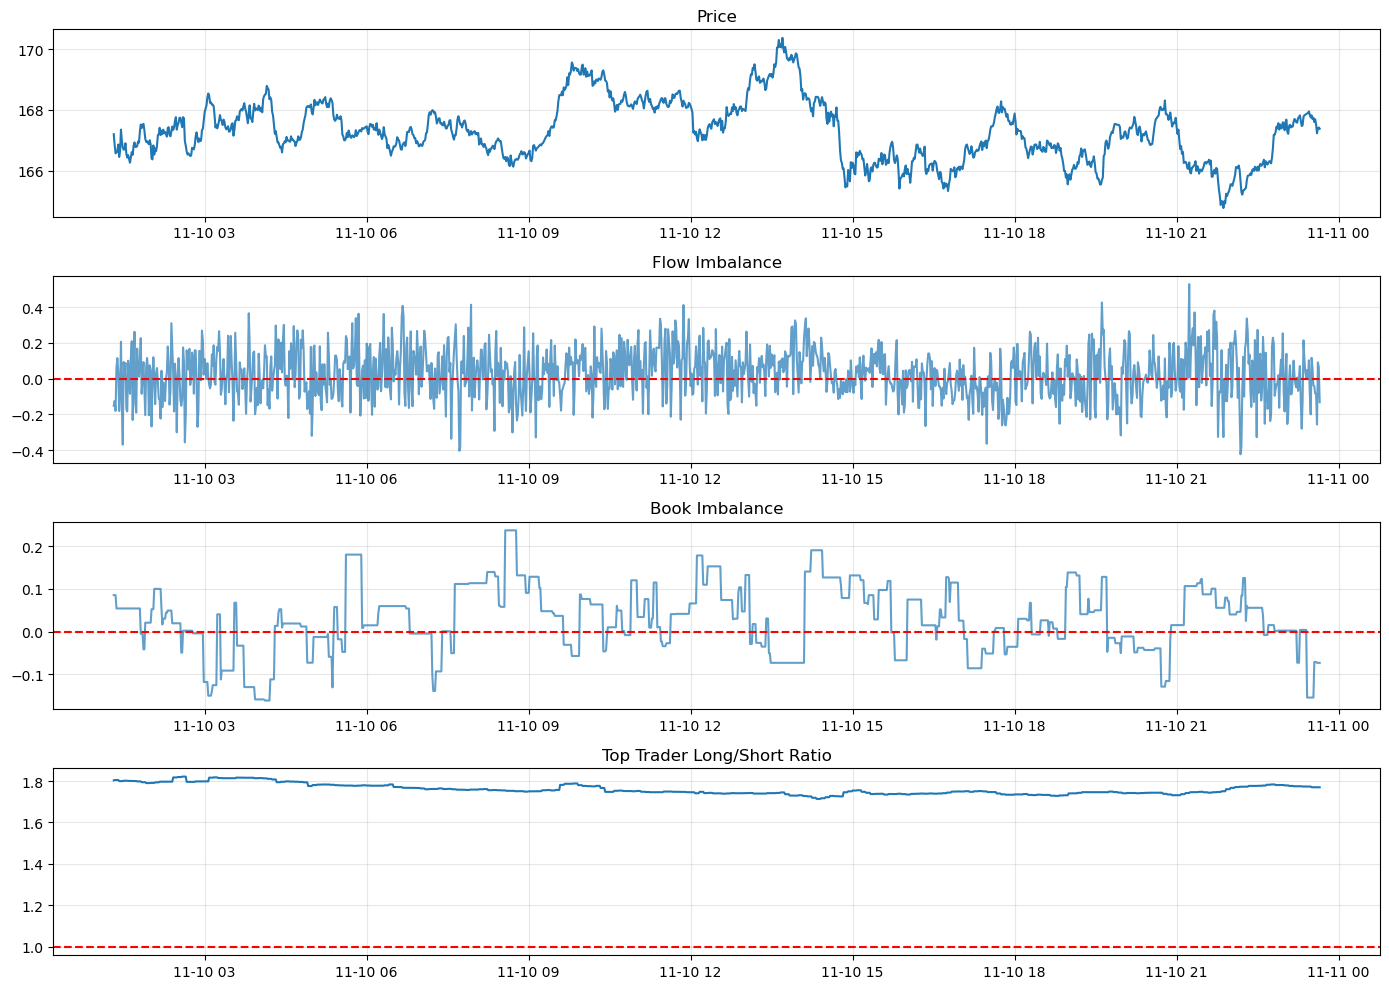

In [93]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(features.index, features['close'])
axes[0].set_title('Price')
axes[0].grid(True, alpha=0.3)

axes[1].plot(features.index, features['flow_imbalance'], alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Flow Imbalance')
axes[1].grid(True, alpha=0.3)

axes[2].plot(features.index, features['book_imbalance'], alpha=0.7)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_title('Book Imbalance')
axes[2].grid(True, alpha=0.3)

axes[3].plot(features.index, features['toptrader_ratio'])
axes[3].axhline(1, color='red', linestyle='--')
axes[3].set_title('Top Trader Long/Short Ratio')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training

We'll use logistic regression to predict the sign of the 5-minute forward return (up vs down), treating this as a binary classification problem. This is a simple linear model that learns which features are most predictive of price direction: positive coefficients mean that feature predicts up moves, negative means down moves. The model only sees data up to time t to predict t + 5, respecting causality and avoiding look-ahead bias. If we can beat 50% accuracy (random coin flip), we have a tradeable signal; anything above 52-53% is typically profitable after transaction costs in futures markets.

In [140]:
train_start = 30
test_start = len(features) - 30

In [141]:
train_features = features.iloc[train_start:test_start].copy()
test_features = features.iloc[test_start:].copy()

In [142]:
print(f"Train set: {len(train_features)} rows ({train_features.index[0]} to {train_features.index[-1]})")
print(f"Test set: {len(test_features)} rows ({test_features.index[0]} to {test_features.index[-1]})")

Train set: 1281 rows (2025-11-10 01:49:00 to 2025-11-10 23:09:00)
Test set: 30 rows (2025-11-10 23:10:00 to 2025-11-10 23:39:00)


In [143]:
feature_cols = ['returns', 'log_returns', 'volatility', 'buy_volume_ratio', 
                'flow_imbalance', 'trade_intensity', 'book_imbalance', 'total_liquidity',
                'open_interest', 'toptrader_ratio', 'longshort_ratio', 'taker_ratio',
                'momentum_5', 'momentum_20', 'volatility_ratio', 'volume_surge',
                'liquidity_change', 'oi_change', 'price_vs_sma20', 'price_vs_sma60']

In [144]:
X_train = train_features[feature_cols]
y_train = train_features['forward_return_5']

X_test = test_features[feature_cols]
y_test = test_features['forward_return_5']

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [146]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [147]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_binary)

LogisticRegression(max_iter=1000, random_state=42)

In [148]:
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test_scaled)
train_probs = model.predict_proba(X_train_scaled)[:, 1]
test_probs = model.predict_proba(X_test_scaled)[:, 1]

In [149]:
from sklearn.metrics import accuracy_score, classification_report

print("Train:")
print(f"Accuracy: {accuracy_score(y_train_binary, train_preds):.4f}")
print(f"\n{classification_report(y_train_binary, train_preds)}")

print("Test:")
print(f"Accuracy: {accuracy_score(y_test_binary, test_preds):.4f}")
print(f"\n{classification_report(y_test_binary, test_preds)}")

Train:
Accuracy: 0.6300

              precision    recall  f1-score   support

           0       0.62      0.57      0.59       611
           1       0.64      0.69      0.66       670

    accuracy                           0.63      1281
   macro avg       0.63      0.63      0.63      1281
weighted avg       0.63      0.63      0.63      1281

Test:
Accuracy: 0.8333

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.85      0.79      0.81        14

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30



In [150]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("Top 10 Most Important Features")
feature_importance.head(10)

Top 10 Most Important Features


,feature,coefficient
9,toptrader_ratio,0.800679
10,longshort_ratio,-0.648891
12,momentum_5,0.346990
18,price_vs_sma20,-0.337179
6,book_imbalance,0.299223
13,momentum_20,-0.253811
5,trade_intensity,-0.237368
16,liquidity_change,-0.194374
4,flow_imbalance,-0.190253
14,volatility_ratio,-0.141679


In [151]:
test_features['prediction'] = test_preds
test_features['prob_up'] = test_probs
test_features['actual_direction'] = (y_test > 0).astype(int)
test_features['position'] = np.where(test_features['prediction'] == 1, 1, -1)
test_features['strategy_return'] = test_features['position'] * test_features['forward_return_5']
test_features['cumulative_pnl'] = test_features['strategy_return'].cumsum()

np.random.seed(42)
test_features['random_position'] = np.random.choice([-1, 1], size=len(test_features))
test_features['random_return'] = test_features['random_position'] * test_features['forward_return_5']
test_features['random_cumulative_pnl'] = test_features['random_return'].cumsum()

test_features['buy_hold_return'] = test_features['forward_return_5']
test_features['buy_hold_cumulative'] = test_features['buy_hold_return'].cumsum()
test_features['price_change'] = (test_features['close'] - test_features['close'].iloc[0]) / test_features['close'].iloc[0]

In [152]:
print(f"Our Strategy PnL: {test_features['cumulative_pnl'].iloc[-1]:.4%}")
print(f"Buy & Hold PnL: {test_features['buy_hold_cumulative'].iloc[-1]:.4%}")
print(f"Random PnL: {test_features['random_cumulative_pnl'].iloc[-1]:.4%}")
print(f"Market (Price Change): {test_features['price_change'].iloc[-1]:.4%}")

print(f"\nSharpe Ratios:")
print(f"Our Strategy: {test_features['strategy_return'].mean() / test_features['strategy_return'].std():.2f}")
print(f"Buy & Hold: {test_features['buy_hold_return'].mean() / test_features['buy_hold_return'].std():.2f}")
print(f"Random: {test_features['random_return'].mean() / test_features['random_return'].std():.2f}")

Our Strategy PnL: 2.7500%
Buy & Hold PnL: -0.3497%
Random PnL: -0.9228%
Market (Price Change): -0.1372%

Sharpe Ratios:
Our Strategy: 1.00
Buy & Hold: -0.09
Random: -0.24


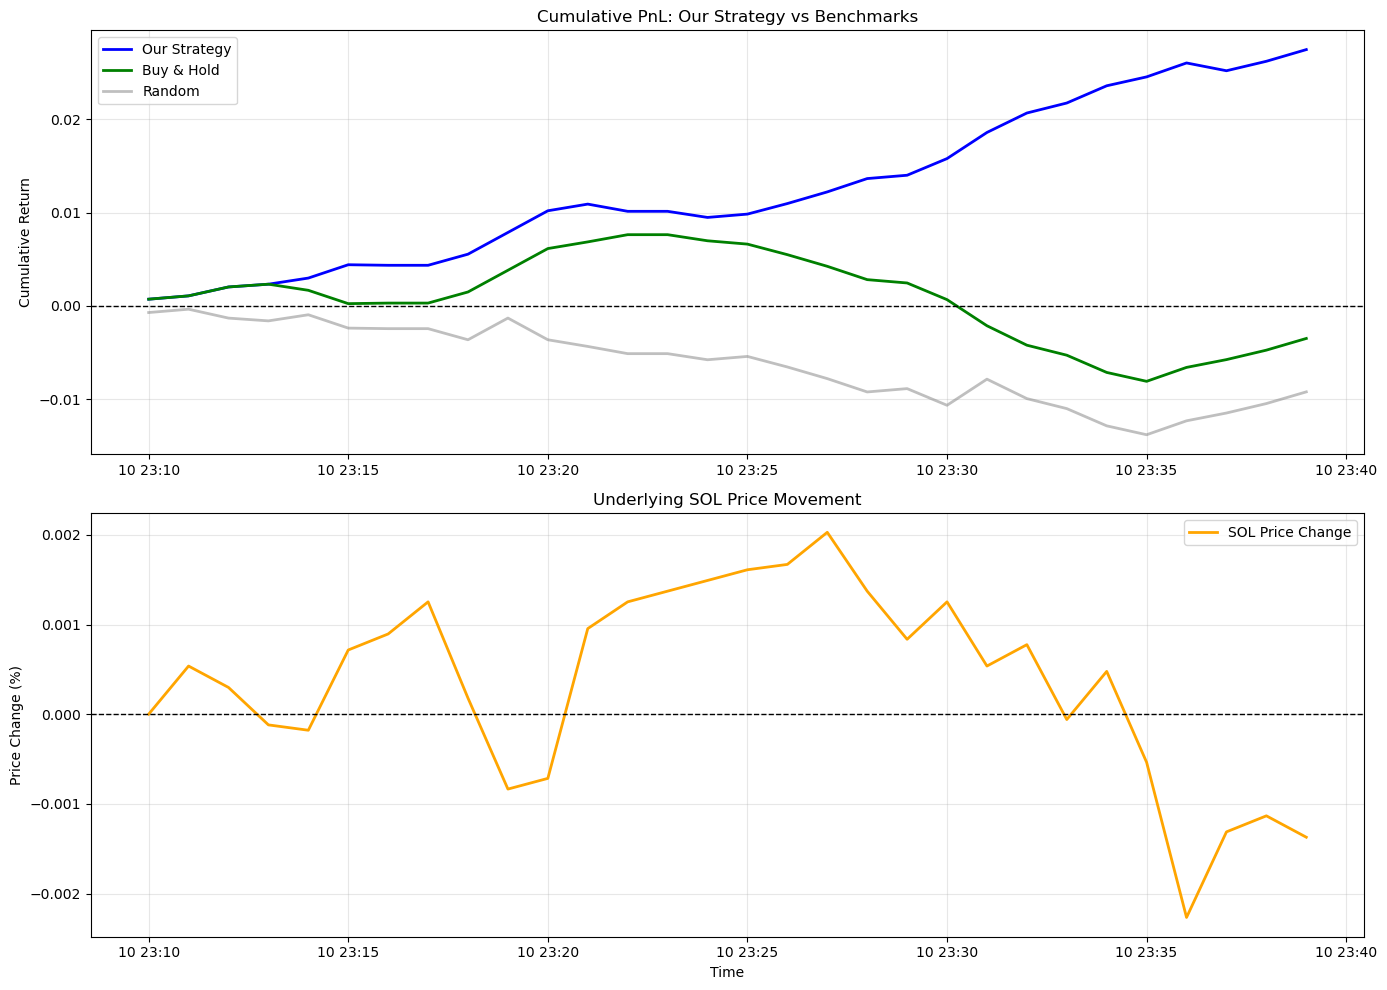

In [153]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(test_features.index, test_features['cumulative_pnl'], label='Our Strategy', linewidth=2, color='blue')
axes[0].plot(test_features.index, test_features['buy_hold_cumulative'], label='Buy & Hold', linewidth=2, color='green')
axes[0].plot(test_features.index, test_features['random_cumulative_pnl'], label='Random', linewidth=2, color='gray', alpha=0.5)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('Cumulative PnL: Our Strategy vs Benchmarks')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_features.index, test_features['price_change'], label='SOL Price Change', linewidth=2, color='orange')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_ylabel('Price Change (%)')
axes[1].set_xlabel('Time')
axes[1].set_title('Underlying SOL Price Movement')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We evaluate our logistic regression model on a held-out test set (last 30 minutes of the day) that the model never saw during training, ensuring no look-ahead bias. At each time t, we only use features computed from data up to time t to predict the return from t to t+5 minutes, respecting causality. We compare our strategy against three benchmarks: (1) random trading (coin flip for direction), (2) buy-and-hold (always long), and (3) the underlying market movement (price change).

To evolve this into a real market-making system, we're going to need to make a lot of changes. First, we must collect live order book data via Binance WebSocket for actual tick-level LOB snapshots with full depth, not just the limited historical aggregates. This enables proper market-making actions (bid/ask placement and sizing) rather than simple directional bets (but on our very constrained baseline we did pretty solid!). Second, we need to incorporate the multi-modal architecture from our proposal: on-chain metrics (Helius/Flipside for transaction flow, active addresses, DeFi TVL) and sentiment signals (FinBERT-scored news from CryptoPanic) to capture alpha beyond just price/flow data. Third, we must build a realistic simulator with proper microstructure (queue priority, partial fills, adverse selection) and transaction costs (taker fees ~0.04%, funding payments, slippage), then train an RL agent (PPO/DQN) with inventory-aware rewards rather than this simple classification approach. Finally, implement walk-forward validation across weeks/months of data with proper train/val/test splits to ensure the strategy isn't overfitting to one day's market regime... what works on Nov 1st might fail on Nov 2nd if market conditions shift.